# 6. Rendering pipeline

## Overview

This tutorial shows how to script a simple rendering pipeline to render depth images.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Write a custom rendering pipeline</li>
  <li>Generate rays using the scene's sensor</li>
  <li>Splat values to the film</li>
  <li>Convert XYZ bitmap to RGB (with gamma correction)</li>
</ul>
    
</div>


### Step 1 - setup


In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('/home/speierers/projects/mitsuba2-symbolic/build/python')

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('llvm_ad_rgb')

In [4]:
from mitsuba.core.xml import load_file
scene = load_file('../scenes/cbox.xml')

2021-04-23 12:09:46 INFO main [xml.cpp:1239] Loading XML file "../scenes/cbox.xml" ..

2021-04-23 12:09:46 INFO main [xml.cpp:1240] Using variant "llvm_ad_rgb"

2021-04-23 12:09:46 INFO main [Scene] Embree ready. (took 11ms)

### Step 2 - prepare the pipeline

In order to build our custom rendering pipeline, we will need to access the different elements provided in the scene (e.g. sensor, sampler, film). Note that we can of course decide to swap one of those with our own instances, e.g. using the `mitsuba.core.xml.load_dict` as done in previous tutorials.

In [5]:
sensor = scene.sensors()[0]

film = sensor.film()
film_size = film.crop_size()

film.prepare([c for c in 'XYZAW'])

As explained in [Tutorial 04](...), we need to seed the sampler before using it.

In [6]:
spp = 32 # Samples per pixel
total_sample_count = ek.hprod(film_size) * spp

sampler = sensor.sampler()
if sampler.wavefront_size() != total_sample_count:
    sampler.seed(0, total_sample_count)

### Step 3 - generate camera rays

Enumerate discrete sample & pixel indices, and uniformly sample positions within each pixel.

In [7]:
from mitsuba.core import Float, UInt32, Vector2f

# Sample pixel locations
pos = ek.arange(UInt32, total_sample_count)
pos //= spp
pos = Vector2f(Float(pos  % int(film_size[0])),
               Float(pos // int(film_size[0])))
pos += sampler.next_2d()

# Sample rays starting from the camera sensor
rays, weights = sensor.sample_ray_differential(
    time=0,
    sample1=sampler.next_1d(),
    sample2=pos / Vector2f(film_size),
    sample3=0
)

### Step 4 - direct illumination integrator

Instead of calling the scene's integrator, we build our own small integrator.

In [8]:
from mitsuba.core import Spectrum
from mitsuba.render import BSDFContext

result = Spectrum(0)

# Intersect rays with the scene geometry
si = scene.ray_intersect(rays)
active = si.is_valid()

# Visible emitters
result[active] = result + si.emitter(scene, active).eval(si, active)

# Sample a direction from the intersection point towards an emitter
ds, emitter_val = scene.sample_emitter_direction(si, sampler.next_2d(active), True, active)
active &= ek.neq(ds.pdf, 0.0)

# Evaluate the BSDF for the sampled emitter direction
bsdf = si.bsdf(rays)
wo = si.to_local(ds.d)
bsdf_val = bsdf.eval(BSDFContext(), si, wo, active)

# Read the depth value `t` of the sampled surface interaction
result[active] = result + bsdf_val * emitter_val

### Step 5 - splatting onto the film

In [9]:
from mitsuba.render import ImageBlock

block = ImageBlock(
    film.crop_size(),
    channel_count=5,
    filter=film.reconstruction_filter(),
    border=False
)

# Ensure the values in the allocated buffer are initialized to zero
block.clear()

# Splat the values to the ImageBlock at the corresponding pixel locations
block.put(pos, rays.wavelengths, result, 1)

# Add this image block to the film for later convertion to Bitmap (e.g. HDR)
film.put(block)

### Step 6 - convertion from XYZ to RGB

In [10]:
from mitsuba.core import Bitmap, Struct
xyz_image = film.bitmap(raw=True)
rgb_image = xyz_image.convert(Bitmap.PixelFormat.RGB, Struct.Type.UInt8, srgb_gamma=True)

Let's now have a look at the image we have produced in this tutorial! 

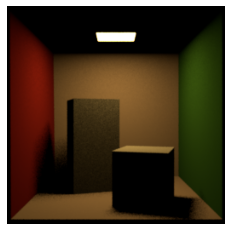

In [11]:
from matplotlib import pyplot as plt
plt.imshow(rgb_image); plt.axis('off');

### *Reference API*

- [<code>mitsuba.core.Bitmap</code>](...)
- [<code>mitsuba.core.Bitmap.convert</code>](...)
- [<code>mitsuba.render.ImageBlock</code>](...)
- [<code>mitsuba.render.ImageBlock.clear</code>](...)
- [<code>mitsuba.render.ImageBlock.put</code>](...)
- [<code>mitsuba.render.Film.put</code>](...)
- [<code>mitsuba.render.Film.bitmap</code>](...)
- [<code>mitsuba.render.Scene.ray_intersect</code>](...)
- [<code>mitsuba.render.Scene.sample_emitter_direction</code>](...)